In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sklearn
import math
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.filters import sobel,laplace
from PIL import Image
import tensorflow as tf
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
lena = np.asarray(Image.open('lena_gray.bmp'))

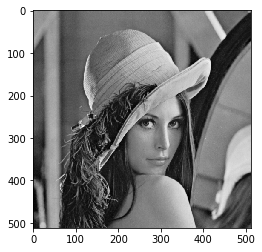

In [3]:
plt.imshow(lena, cmap = 'gray')

In [4]:
lena


array([[160, 160, 160, ..., 169, 154, 129],
       [161, 160, 159, ..., 168, 154, 129],
       [160, 161, 160, ..., 168, 154, 129],
       ...,
       [ 50,  49,  55, ..., 106, 103, 104],
       [ 49,  50,  58, ..., 107, 109, 111],
       [ 50,  49,  59, ..., 107, 108, 112]], dtype=uint8)

In [5]:
lena = lena / 255

In [6]:
def block_image_y(image):
    arr = np.empty(shape=(1024,256))
    for i in range(0,32):
        for j in range(0,32):
            arr[32*i+j] = image[i*16:i*16 + 16,j*16:j*16 + 16].flatten()
            
    return arr
    

In [7]:
def block_image_X(image):
    arr = np.empty(shape=(1024,16,16))
    for i in range(0,32):
        for j in range(0,32):
            arr[32*i+j] = image[i*16:i*16 + 16,j*16:j*16 + 16]
            
    return arr

In [8]:
y = block_image_y(lena)

In [9]:
test = lena[0:16,0:16]

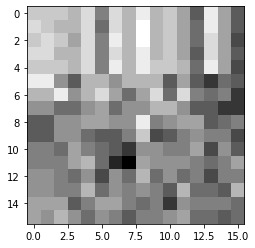

In [10]:
plt.imshow(lena[0:16,0:16], cmap='gray')

In [11]:
#binary search style encoding of location- halving the image in pairs of bits
#with first bit in each pair denoting vertical half that pixel is in and second
#bit denoting horizontal half
#I think this will allow network to take account of more global features better as each bit corresponds to a particular
#region in the image. I think will be useful for natural images where there are often large regions of similar intensity
#and colour. Probably no better than co-ordinate representation for random images, as this representation has the same number of
#bits as would be in co-ordinate representation.

#e.g the blackest pixel in lena[0:8,0:8] has location 100111

def encode_location(coordinates, shape):
    i = coordinates[0]
    j = coordinates[1]
   
    if (shape[0] == shape[1]) and (math.log(shape[0], 2).is_integer()):
        power = int(math.log(shape[0], 2))
        arr = np.zeros(2*power)
    else:
        print("sorry this doesn't yet work for non-square, non-powers of 2 shapes")
        
    i_p = i
    j_p = j
    for p in range(1,power + 1):
        i_p = i_p - np.sign(i_p + 0.5)*(shape[0] // 2**p)
        j_p = j_p - np.sign(j_p + 0.5)*(shape[1] // 2**p)
        arr[2*p - 2] = (np.sign(i_p + 0.5) + 1) // 2
        arr[2*p - 1] = (np.sign(j_p + 0.5) + 1) // 2
        
    return arr          

In [12]:
def coords_to_binary(coordinates, shape):
    
    nbits0 = int(math.ceil(math.log(shape[0], 2)))
    nbits1 = int(math.ceil(math.log(shape[1], 2)))
    
    bin0 = format(coordinates[0], '0' + (str(nbits0) + 'b'))
    bin1 = format(coordinates[1], '0' + (str(nbits1) + 'b'))
     
    return np.array(list(map(int, bin0 + bin1)))
    
    

In [13]:
def gen_training_pos_encode(image):
    shape = image.shape
    data = np.empty((shape[0]*shape[1], int(math.log(shape[0],2)) + int(math.log(shape[1],2)) + 1))
    for i in range(shape[0]):
        for j in range(shape[1]):
            data[shape[1]*i + j][:-1] = encode_location((i,j),shape)
            data[shape[1]*i + j][-1] = image[i,j]
    return data

In [14]:
def gen_training_binary_coords(image):
    shape = image.shape
    data = np.empty((shape[0]*shape[1], int(math.log(shape[0],2)) + int(math.log(shape[1],2)) + 1))
    for i in range(shape[0]):
        for j in range(shape[1]):
            data[shape[1]*i + j][:-1] = coords_to_binary((i,j),shape)
            data[shape[1]*i + j][-1] = image[i,j]
            
    return data

In [15]:
def gen_training_coords(image, repeats=1):
    shape = image.shape
    data = np.empty((shape[0]*shape[1], 2*repeats + 1))
    for i in range(shape[0]):
        for j in range(shape[1]):
            data[shape[1]*i + j][:2*repeats] = [(i - (shape[0]-1)/2)/((shape[0]-1)/2),(j - (shape[0]-1)/2)/((shape[0]-1)/2)] * repeats
            data[shape[1]*i + j][2*repeats:] = image[i,j]
            
    return data
            

In [16]:
train = gen_training_binary_coords(lena)

In [17]:
X = train[:, :-1]
y = train[:,-1]

In [18]:
X[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [19]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import RandomUniform


In [20]:
from tensorflow.math import sin as Sine

In [21]:
w0 = 30
n = len(X[0])


In [22]:
def hfSin(x):
    return Sine(w0*x)

In [83]:
#initial testing model
model = Sequential()
model.add(Dense(8, activation='tanh'))
#model.add(Dense(36, activation='tanh'))
model.add(Dense(8, activation='tanh'))
#model.add(Dense(8, activation='tanh'))
#model.add(Dense(9, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mse', optimizer='adam')

In [23]:
#bigger model
model = Sequential()
model.add(Dense(72, activation='tanh'))
model.add(Dense(72, activation='tanh'))
model.add(Dense(72, activation='tanh'))
model.add(Dense(72, activation='tanh'))
model.add(Dense(18, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mse', optimizer='adam')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [36]:
#SIREN
model = Sequential()
model.add(Dense(72, activation=hfSin, kernel_initializer=RandomUniform(minval=-1/n, maxval=1/n)))
model.add(Dense(72, activation=hfSin, kernel_initializer=RandomUniform(minval=-np.sqrt(6/n)/w0, maxval=np.sqrt(6/n)/w0)))
model.add(Dense(72, activation=hfSin, kernel_initializer=RandomUniform(minval=-np.sqrt(6/n)/w0, maxval=np.sqrt(6/n)/w0)))
model.add(Dense(72, activation=hfSin, kernel_initializer=RandomUniform(minval=-np.sqrt(6/n)/w0, maxval=np.sqrt(6/n)/w0)))
model.add(Dense(18, activation=hfSin, kernel_initializer=RandomUniform(minval=-np.sqrt(6/n)/w0, maxval=np.sqrt(6/n)/w0)))
model.add(Dense(3, activation='sigmoid'))

model.compile(loss='mse', optimizer='adam')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [24]:
model.fit(x=X, y=y, epochs= 256, batch_size = 4096, verbose=1)

Epoch 1/256
262144/262144 [==============================] - 2s 7us/sample - loss: 0.0299
Epoch 2/256
262144/262144 [==============================] - 1s 5us/sample - loss: 0.0240
Epoch 3/256
262144/262144 [==============================] - 1s 5us/sample - loss: 0.0209
Epoch 4/256
262144/262144 [==============================] - 1s 5us/sample - loss: 0.0173
Epoch 5/256
262144/262144 [==============================] - 1s 5us/sample - loss: 0.0148
Epoch 6/256
262144/262144 [==============================] - 1s 6us/sample - loss: 0.0132
Epoch 7/256
262144/262144 [==============================] - 1s 6us/sample - loss: 0.0119
Epoch 8/256
262144/262144 [==============================] - 1s 5us/sample - loss: 0.0109
Epoch 9/256
262144/262144 [==============================] - 1s 5us/sample - loss: 0.0099
Epoch 10/256
262144/262144 [==============================] - 1s 6us/sample - loss: 0.0091
Epoch 11/256
262144/262144 [==============================] - 1s 5us/sample - loss: 0.0084
Epoch 12

262144/262144 [==============================] - 1s 6us/sample - loss: 0.0019
Epoch 92/256
262144/262144 [==============================] - 1s 6us/sample - loss: 0.0019
Epoch 93/256
262144/262144 [==============================] - 1s 5us/sample - loss: 0.0019
Epoch 94/256
262144/262144 [==============================] - 1s 5us/sample - loss: 0.0019
Epoch 95/256
262144/262144 [==============================] - 1s 5us/sample - loss: 0.0019
Epoch 96/256
262144/262144 [==============================] - 1s 5us/sample - loss: 0.0019
Epoch 97/256
262144/262144 [==============================] - 1s 5us/sample - loss: 0.0019
Epoch 98/256
262144/262144 [==============================] - 1s 5us/sample - loss: 0.0019
Epoch 99/256
262144/262144 [==============================] - 1s 5us/sample - loss: 0.0018
Epoch 100/256
262144/262144 [==============================] - 1s 6us/sample - loss: 0.0018
Epoch 101/256
262144/262144 [==============================] - 1s 5us/sample - loss: 0.0018
Epoch 102/

262144/262144 [==============================] - 1s 5us/sample - loss: 0.0013
Epoch 181/256
262144/262144 [==============================] - 1s 5us/sample - loss: 0.0013
Epoch 182/256
262144/262144 [==============================] - 1s 5us/sample - loss: 0.0013
Epoch 183/256
262144/262144 [==============================] - 1s 5us/sample - loss: 0.0013
Epoch 184/256
262144/262144 [==============================] - 1s 5us/sample - loss: 0.0013
Epoch 185/256
262144/262144 [==============================] - 1s 5us/sample - loss: 0.0013
Epoch 186/256
262144/262144 [==============================] - 1s 5us/sample - loss: 0.0013
Epoch 187/256
262144/262144 [==============================] - 1s 5us/sample - loss: 0.0013
Epoch 188/256
262144/262144 [==============================] - 1s 5us/sample - loss: 0.0013
Epoch 189/256
262144/262144 [==============================] - 1s 5us/sample - loss: 0.0013
Epoch 190/256
262144/262144 [==============================] - 1s 5us/sample - loss: 0.0013
Ep

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  1368      
_________________________________________________________________
dense_1 (Dense)              multiple                  5256      
_________________________________________________________________
dense_2 (Dense)              multiple                  5256      
_________________________________________________________________
dense_3 (Dense)              multiple                  5256      
_________________________________________________________________
dense_4 (Dense)              multiple                  1314      
_________________________________________________________________
dense_5 (Dense)              multiple                  19        
Total params: 18,469
Trainable params: 18,469
Non-trainable params: 0
____________________________________________________

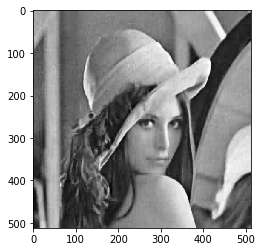

In [27]:
result = model.predict(X).reshape(lena.shape)
plt.imshow(result, cmap='gray')

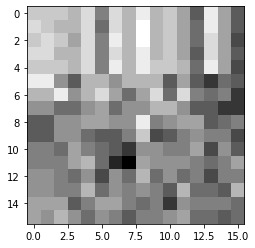

In [87]:
plt.imshow(test, cmap='gray')

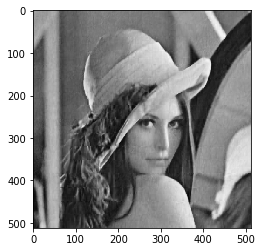

In [113]:
result = model.predict(X).reshape((512,512))
plt.imshow(result, cmap='gray')

Promising first result

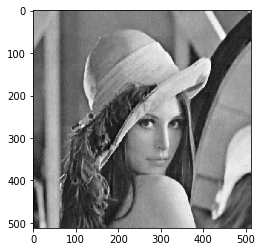

In [118]:
result = model.predict(X).reshape((512,512))
plt.imshow(result, cmap='gray')

below: quite large model trained with tanh, 5000 epochs, best result yet

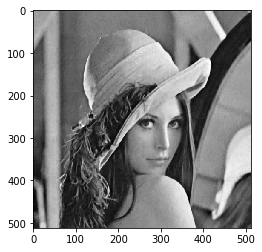

In [121]:
result = model.predict(X).reshape((512,512))
plt.imshow(result, cmap='gray')


Below: smallish model trained with tanh, 5000 epochs

In [127]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_91 (Dense)             multiple                  684       
_________________________________________________________________
dense_92 (Dense)             multiple                  1332      
_________________________________________________________________
dense_93 (Dense)             multiple                  666       
_________________________________________________________________
dense_94 (Dense)             multiple                  19        
Total params: 2,701
Trainable params: 2,701
Non-trainable params: 0
_________________________________________________________________


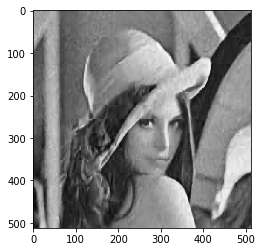

In [132]:
result = model.predict(X).reshape((512,512))
plt.imshow(result, cmap='gray')

Below:small model trained on raw co-ordinates. Interesting result

In [141]:
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_107 (Dense)            multiple                  48        
_________________________________________________________________
dense_108 (Dense)            multiple                  272       
_________________________________________________________________
dense_109 (Dense)            multiple                  136       
_________________________________________________________________
dense_110 (Dense)            multiple                  9         
Total params: 465
Trainable params: 465
Non-trainable params: 0
_________________________________________________________________


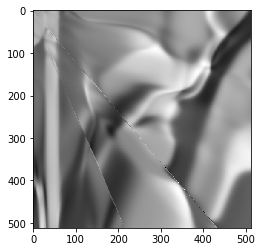

In [142]:
result = model.predict(X).reshape((512,512))
plt.imshow(result, cmap='gray')

Below: raw model trained on (x,y) formatted co-ordinates, larger model.

In [145]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_111 (Dense)            multiple                  216       
_________________________________________________________________
dense_112 (Dense)            multiple                  5256      
_________________________________________________________________
dense_113 (Dense)            multiple                  1314      
_________________________________________________________________
dense_114 (Dense)            multiple                  19        
Total params: 6,805
Trainable params: 6,805
Non-trainable params: 0
_________________________________________________________________


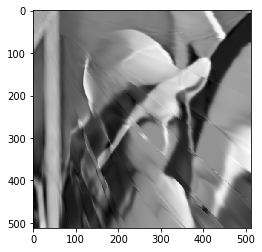

In [146]:
result = model.predict(X).reshape((512,512))
plt.imshow(result, cmap='gray')

same model but with position encoding:

In [153]:
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_115 (Dense)            multiple                  1368      
_________________________________________________________________
dense_116 (Dense)            multiple                  5256      
_________________________________________________________________
dense_117 (Dense)            multiple                  1314      
_________________________________________________________________
dense_118 (Dense)            multiple                  19        
Total params: 7,957
Trainable params: 7,957
Non-trainable params: 0
_________________________________________________________________


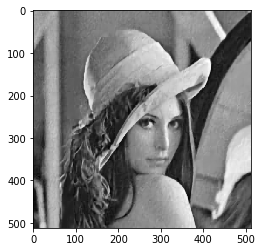

In [154]:
result = model.predict(X).reshape((512,512))
plt.imshow(result, cmap='gray')

same model with exact binary representation of co-ordinates

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  1368      
_________________________________________________________________
dense_1 (Dense)              multiple                  5256      
_________________________________________________________________
dense_2 (Dense)              multiple                  1314      
_________________________________________________________________
dense_3 (Dense)              multiple                  19        
Total params: 7,957
Trainable params: 7,957
Non-trainable params: 0
_________________________________________________________________


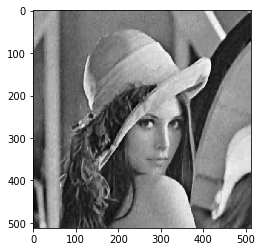

In [52]:
result = model.predict(X).reshape((512,512))
plt.imshow(result, cmap='gray')

In [49]:
from skimage.metrics import structural_similarity as ssim

In [54]:
ssim(lena,result)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  """Entry point for launching an IPython kernel.


0.907305011159276

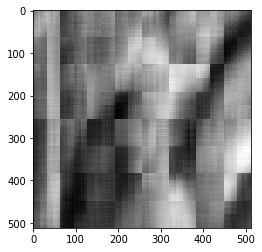

In [57]:
result = model.predict(X).reshape((512,512))
plt.imshow(result, cmap='gray')

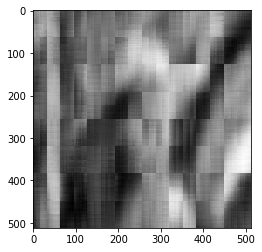

In [66]:
result = model.predict(X).reshape((512,512))
plt.imshow(result, cmap='gray')

In [95]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             multiple                  1368      
_________________________________________________________________
dense_30 (Dense)             multiple                  5256      
_________________________________________________________________
dense_31 (Dense)             multiple                  5256      
_________________________________________________________________
dense_32 (Dense)             multiple                  5256      
_________________________________________________________________
dense_33 (Dense)             multiple                  1314      
_________________________________________________________________
dense_34 (Dense)             multiple                  19        
Total params: 18,469
Trainable params: 18,469
Non-trainable params: 0
__________________________________________________

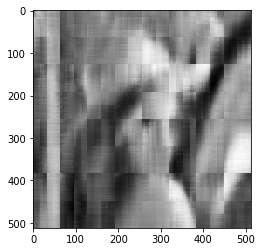

In [96]:
result = model.predict(X).reshape((512,512))
plt.imshow(result, cmap='gray')

In [97]:
ssim(lena,result)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  """Entry point for launching an IPython kernel.


0.7336129180122897

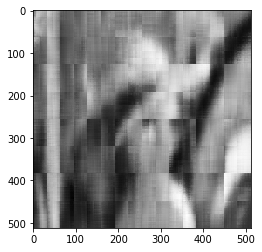

In [105]:
result = model.predict(X).reshape((512,512))
plt.imshow(result, cmap='gray')

In [106]:
ssim(lena,result)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  """Entry point for launching an IPython kernel.


0.743977503771527

## ------------------------------------------

## Experiments with cnn denoising

In [1]:
from tensorflow.compat.v1 import enable_eager_execution

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
enable_eager_execution()

In [28]:
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten
from tensorflow.image import ssim as ssimt
from tensorflow.image import psnr as psnrt

In [71]:
def de_block(arr):
    
    out = np.empty((512,512))
    for i in range(32):
        for j in range(32):
            out[16*i:16*i+16,16*j:16*j+16] = arr[32*i+j]
            
    return out

In [45]:
def ssim_loss(y_true,y_pred):
    
    batch_size = 16
    y_true = tf.reshape(y_true,(batch_size,16,16,1))
    y_pred = tf.reshape(y_pred,(batch_size,16,16,1))
    return (1 - tf.reduce_mean(ssimt(y_true,y_pred,1.0)))

In [81]:
def ssim_loss_full(y_true,y_pred):
    
    batch_size = 1024
    y_true = tf.reshape(y_true,(batch_size,16,16,1))
    y_pred = tf.reshape(y_pred,(batch_size,16,16,1))
    
    true_image = tf.Tensor(de_block(y_true.eval(session=tf.compat.v1.keras.backend.get_session())))
    pred_image = tf.Tensor(de_block(y_pred.eval(session=tf.compat.v1.keras.backend.get_session())))
    return (1 - tf.reduce_mean(ssimt(true_image,pred_image,1.0)))

In [60]:
def psnr_loss(y_true,y_pred):
    batch_size = 16
    y_true = tf.reshape(y_true,(batch_size,16,16,1))
    y_pred = tf.reshape(y_pred,(batch_size,16,16,1))
    return (50.0 - tf.reduce_mean(psnrt(y_true,y_pred,1.0))) / 50.0

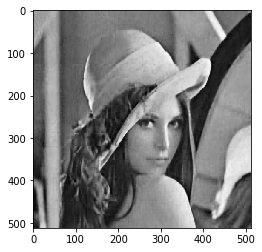

In [30]:
result = model.predict(X).reshape(lena.shape)
plt.imshow(result, cmap='gray')

In [31]:
print('ssim with base image: ' + str(ssim(lena,result,data_range=1.0)))
print('mse with base image: ' + str(mse(lena,result)))
print('PSNR: ' + str(psnr(lena,result)))

ssim with base image: 0.8021593221484492
mse with base image: 0.0010878000720630845
PSNR: 29.634509167503026


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
X = block_image_X(result)
y = block_image_y(lena)

In [33]:
X.shape

(1024, 16, 16)

In [34]:
X = X.reshape(1024,16,16,1)

In [35]:
X.shape

(1024, 16, 16, 1)

In [82]:
model = Sequential()
model.add(Conv2D(filters=8,kernel_size=(3,3),activation='relu',padding='same',input_shape=(16,16,1)))
model.add(MaxPool2D(pool_size=(2,2),strides=2))
model.add(Conv2D(filters=16,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2,2),strides=2))
model.add(Flatten())
model.add(Dense(256,activation='sigmoid'))
model.compile(loss=ssim_loss_full,optimizer='adam')

InvalidArgumentError: You must feed a value for placeholder tensor 'dense_18_target' with dtype float and shape [?,?]
	 [[node dense_18_target (defined at <ipython-input-82-59a0c1f94710>:8) ]]

Original stack trace for 'dense_18_target':
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 583, in start
    self.io_loop.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 153, in start
    self.asyncio_loop.run_forever()
  File "C:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 538, in run_forever
    self._run_once()
  File "C:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 1782, in _run_once
    handle._run()
  File "C:\ProgramData\Anaconda3\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 787, in inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 541, in execute_request
    user_expressions, allow_stdin,
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2858, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2886, in _run_cell
    return runner(coro)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3063, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3254, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-82-59a0c1f94710>", line 8, in <module>
    model.compile(loss=ssim_loss_full,optimizer='adam')
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\tracking\base.py", line 457, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py", line 307, in compile
    endpoint.create_training_target(t, run_eagerly=self.run_eagerly)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py", line 3100, in create_training_target
    dtype=target_dtype)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\backend.py", line 998, in placeholder
    x = array_ops.placeholder(dtype, shape=shape, name=name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py", line 2143, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 6261, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3616, in create_op
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [53]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 16, 16, 8)         80        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 16)          1168      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
Total params: 67,040
Trainable params: 67,040
Non-trainable params: 0
__________________________________________________

In [62]:
model.fit(x=X, y=y, epochs= 256, batch_size = 16 , verbose=1)

Epoch 1/256
1024/1024 [==============================] - 1s 824us/sample - loss: 0.6305
Epoch 2/256
1024/1024 [==============================] - 0s 304us/sample - loss: 0.6062
Epoch 3/256
1024/1024 [==============================] - 0s 303us/sample - loss: 0.4850
Epoch 4/256
1024/1024 [==============================] - 0s 317us/sample - loss: 0.4465
Epoch 5/256
1024/1024 [==============================] - 0s 309us/sample - loss: 0.4276
Epoch 6/256
1024/1024 [==============================] - 0s 340us/sample - loss: 0.4217
Epoch 7/256
1024/1024 [==============================] - 0s 305us/sample - loss: 0.4105
Epoch 8/256
1024/1024 [==============================] - 0s 315us/sample - loss: 0.4060
Epoch 9/256
1024/1024 [==============================] - 0s 312us/sample - loss: 0.4040
Epoch 10/256
1024/1024 [==============================] - 0s 300us/sample - loss: 0.4000
Epoch 11/256
1024/1024 [==============================] - 0s 303us/sample - loss: 0.3993
Epoch 12/256
1024/1024 [======

1024/1024 [==============================] - 0s 301us/sample - loss: 0.3554
Epoch 94/256
1024/1024 [==============================] - 0s 316us/sample - loss: 0.3588
Epoch 95/256
1024/1024 [==============================] - 0s 299us/sample - loss: 0.3587
Epoch 96/256
1024/1024 [==============================] - 0s 312us/sample - loss: 0.3557
Epoch 97/256
1024/1024 [==============================] - 0s 309us/sample - loss: 0.3547
Epoch 98/256
1024/1024 [==============================] - 0s 309us/sample - loss: 0.3543
Epoch 99/256
1024/1024 [==============================] - 0s 305us/sample - loss: 0.3561
Epoch 100/256
1024/1024 [==============================] - 0s 301us/sample - loss: 0.3558
Epoch 101/256
1024/1024 [==============================] - 0s 320us/sample - loss: 0.3549
Epoch 102/256
1024/1024 [==============================] - 0s 297us/sample - loss: 0.3544
Epoch 103/256
1024/1024 [==============================] - 0s 323us/sample - loss: 0.3601
Epoch 104/256
1024/1024 [=====

1024/1024 [==============================] - 0s 300us/sample - loss: 0.3455
Epoch 185/256
1024/1024 [==============================] - 0s 300us/sample - loss: 0.3484
Epoch 186/256
1024/1024 [==============================] - 0s 314us/sample - loss: 0.3454
Epoch 187/256
1024/1024 [==============================] - 0s 299us/sample - loss: 0.3483
Epoch 188/256
1024/1024 [==============================] - 0s 324us/sample - loss: 0.3473
Epoch 189/256
1024/1024 [==============================] - 0s 344us/sample - loss: 0.3485
Epoch 190/256
1024/1024 [==============================] - 0s 321us/sample - loss: 0.3464
Epoch 191/256
1024/1024 [==============================] - 0s 339us/sample - loss: 0.3509
Epoch 192/256
1024/1024 [==============================] - 0s 336us/sample - loss: 0.3464
Epoch 193/256
1024/1024 [==============================] - 0s 310us/sample - loss: 0.3460
Epoch 194/256
1024/1024 [==============================] - 0s 306us/sample - loss: 0.3496
Epoch 195/256
1024/1024 

In [63]:
result_conv = de_block(model.predict(X).reshape(1024,16,16))

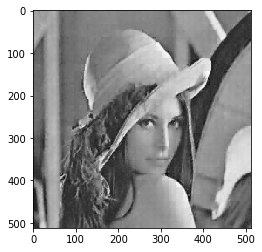

In [62]:
plt.imshow(result_conv,cmap='gray')

In [64]:
print('ssim with base image: ' + str(ssim(lena,result,data_range=1.0)))
print('mse with base image: ' + str(mse(lena,result)))
print('PSNR: ' + str(psnr(lena,result)))

ssim with base image: 0.8034225722380435
mse with base image: 0.001036872628843159
PSNR: 29.842745897903434


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  This is separate from the ipykernel package so we can avoid doing imports until


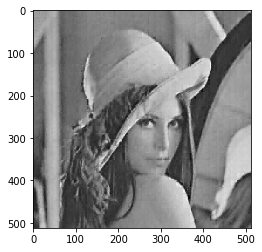

In [43]:
plt.imshow(result_conv,cmap='gray')

In [44]:
print('ssim with base image: ' + str(ssim(lena,result,data_range=1.0)))
print('mse with base image: ' + str(mse(lena,result)))
print('PSNR: ' + str(psnr(lena,result)))

ssim with base image: 0.8021593221484492
mse with base image: 0.0010878000720630845
PSNR: 29.634509167503026


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  This is separate from the ipykernel package so we can avoid doing imports until


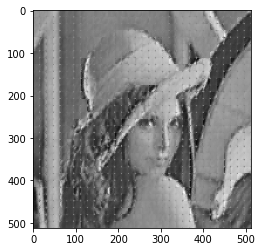

In [50]:
plt.imshow(result_conv,cmap='gray')

#### psnr loss '1/psnr':

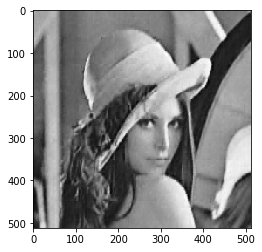

In [58]:
plt.imshow(result_conv,cmap='gray')

In [59]:
print('ssim with base image: ' + str(ssim(lena,result,data_range=1.0)))
print('mse with base image: ' + str(mse(lena,result)))
print('PSNR: ' + str(psnr(lena,result)))

ssim with base image: 0.8021593221484492
mse with base image: 0.0010878000720630845
PSNR: 29.634509167503026


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  This is separate from the ipykernel package so we can avoid doing imports until


#### psnr loss '(50-psnr)/50':

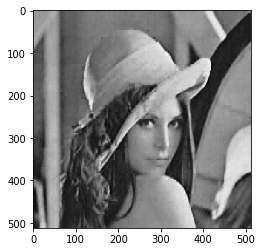

In [64]:
plt.imshow(result_conv,cmap='gray')

In [65]:
print('ssim with base image: ' + str(ssim(lena,result,data_range=1.0)))
print('mse with base image: ' + str(mse(lena,result)))
print('PSNR: ' + str(psnr(lena,result)))

ssim with base image: 0.8021593221484492
mse with base image: 0.0010878000720630845
PSNR: 29.634509167503026


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  This is separate from the ipykernel package so we can avoid doing imports until
